Refs:

- Original paper: Kirkpatrick, S., Gelatt, C.D., and Vecchi, M.P., “Optimization by Simulated
Annealing,” Science, Volume 220, Number 4598, 13 May 1983, pp. 671-
680

### Nota:
Podemos ver la comparación entre 4 distintos algoritmos en el siguiente link: https://www.youtube.com/watch?v=q6fPk0--eHY

- Random path -> start a city and randomly select the next city from the remaining not visited cities until all cities are visited.
- Greedy Algorithm -> start a city select as next city the unvisited city that is closest to the current city 
- 2-Opt -> First create a random tour, and then optimize this with the 2-opt algorithm
- Simulated Annealing -> First create a random tour, and then optimize this with 2-opt in combination with simulated annealing.

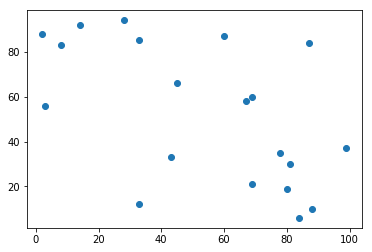

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
w_size = 100
n_cities = 20
#cities = (np.random.random((n_cities,2))*w_size).astype(int)
cities = np.array([[ 2,88],[87,84],[84,6],[99,37], [60, 87], [ 8, 83], [43, 33], [45, 66], [28, 94], [ 3, 56], [14, 92], [88, 10], [33, 12], [33, 85], [69, 60], [67, 58], [80, 19], [81, 30], [69, 21], [78, 35]])
plt.scatter(cities[:,0], cities[:,1])
def TSP_cost(cities, solution):
    sol_cities = cities[solution]
    return np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1)))

In [13]:
sol = np.random.permutation(len(cities))
print (sol)

[12 11  2  0  3  9 10 18  8 16 15 17  1  6  7  5 13 19  4 14]


## Creamos una función que para obtener un _vecino_ de cualquier solución

In [14]:
def TSP_neighbour(solution):
    i1 = np.random.randint(len(solution)) # tomamos un indice de la solución (una ciudad)
    i2 = i1+1 if i1<len(solution)-1 else 0 # tomamos el indice siguiente, si es la ultima ciudad tomamos la primera
    r = np.copy(solution) # copiamos la solución 
    r[i1]=solution[i2] # intercambiamos las ciudades
    r[i2]=solution[i1]
    return r # retornamos la solucion mutada

## Usamos las mismas funciones para el TSP de las notas anteriores

In [15]:
def TSP_initialize_population(n_individuals, n_cities):
    r = []
    for i in range(n_individuals):
        r.append(np.random.permutation(n_cities))
    return np.array(r)

def TSP_cost(cities, solution):
    sol_cities = cities[solution]
    return np.sum(np.sqrt(np.sum((sol_cities - np.roll(sol_cities,-1, axis=0))**2, axis=1)))

def TSP_plot_solution(cities, solution):
    plt.scatter(cities[:,0], cities[:,1])
    plt.plot(cities[solution,0].tolist()+[cities[solution[0],0]], cities[solution,1].tolist()+[cities[solution[0],1]])
    plt.scatter(cities[solution[0],0], cities[solution[0],1], marker="x", s=60, c="red", lw="5")
    plt.title("cost %.3f"%(TSP_cost(cities, solution)))
    
def TSP_plot_result(best, bests, means, stds): # equivalente a def TSP_plot_GA_result(best, bests, means, stds)
    fig = plt.figure(figsize=(12,4))           # esta función nos retorna el mejor espécimen de solución
    fig.add_subplot(121)
    plot_evolution(bests, means, stds)
    fig.add_subplot(122)
    TSP_plot_solution(cities, best)

## Hemos un bucle bajando la temperatura

In [23]:
%%writefile code/sa.py

import numpy as np
import matplotlib.pyplot as plt

def plot_evolution(bests, means, stds):
    plt.plot(means, label="means")
    plt.plot(bests, label="bests")
    plt.fill_between(range(len(means)), means-stds, means+stds, color="yellow", alpha=0.2)
    plt.legend()

def run_sa(n_individuals, n_cooling_steps, init_population_function, cost_function, generate_neighbor_function):
          #         run_ga                            run_sa
        
          #        pop_size           =           n_individuals 
    
          # mutation_function                    # generate_neighbor_function
          # crossover_function            
          # crossover_prob
          # mutation_prob 
          # n_iters                   =            n_cooling_steps

    pop = init_population_function(n_individuals) # Crea la poblacion inicial (n_individuals vectores de soluciones)
    # GA -> se determina el numero de individos a cruzar (n_xover_indivs)
    
    mean_costs = []
    std_costs  = []
    best_costs = []
    best_sols  = []

    min_cost = np.inf
    min_sol  = None

    # GA:  se itera según el Número de Generaciones (n_iters)
    
    for T in np.linspace(1,0,n_cooling_steps): # array numpy que empieza en uno y para en cero de len(n_cooling_steps)
        costs = []                             # para cada paso de enfriamiento se declara una lista de costos
        for i in range(len(pop)):              # recorremos las ciudades
            sol = pop[i]                       
            cost_sol = cost_function(sol)      # hallamos costo a cada individuo de la poblacion ->(costo a solucion)

            # generate a neighbour
            nbr = generate_neighbor_function(sol) # un especimen solucion parecido 1 bit mutado
            cost_nbr = cost_function(nbr)         # se le halla el coste a la mutacion

            # if the neighbour is better
            if cost_nbr<cost_sol or np.random.random()<T: # si el costo es menor lo reemplazamos o si estocásticamente
                sol = nbr                                 # es menor que el paso de enfriamiento, el cual se hace cada vez                       
                cost_sol = cost_nbr                       # mas pequeño, por lo tanto es mas dificil que sea una mutacion
                                                          # con coste mayor reemplazada por la original

            pop[i] = sol                                  # Agregamos a la poblacion el individuo solucion
            costs.append(cost_sol)                        # A los costos le agregamos el costo del especímen

            if cost_sol < min_cost:                       # si el costo de la solucion es menor que el mínimo costo hallado
                min_sol  = np.copy(pop[i])                # la solucion mínima sera el especimen
                min_cost = cost_function(pop[i])          # su costo será el mínimo también

        best_costs.append(np.min(costs))                  # agregamos por cada n_cooling_steps el mínimo a la best cost list
        mean_costs.append(np.mean(costs))                 # agregamos por cada n_cooling_steps la media a la mean cost list
        std_costs.append(np.std(costs))                   # agregamos por cada n_cooling_steps el std a la std cost list
 
                                                          # Los convertimos en np.array y los retornamos
    mean_costs = np.array(mean_costs)
    std_costs  = np.array(std_costs)
    best_costs = np.array(best_costs)
    
    return min_sol, best_costs, mean_costs, std_costs

Overwriting code/sa.py


## Con pocos individuos y pocos pasos de enfriamiento

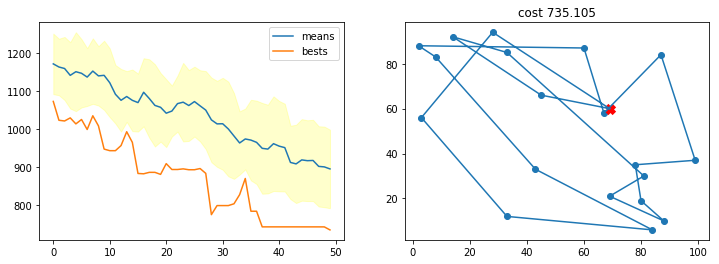

In [17]:
%run code/sa.py

n_individuals = 10
n_cooling_steps = 50


bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour)


TSP_plot_result(bestsol, bests, means, stds)

## Con pocos individuos y muchos pasos de enfriamiento

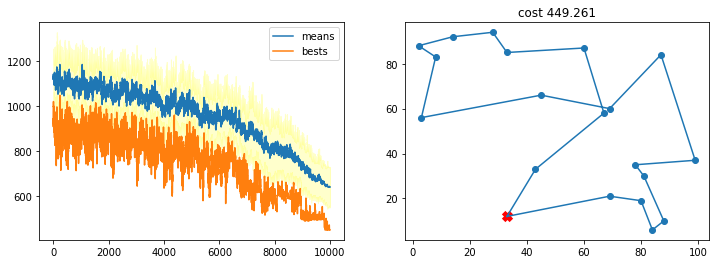

In [18]:
%run code/sa.py

n_individuals = 20
n_cooling_steps = 10000

bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour)


TSP_plot_result(bestsol, bests, means, stds)

## Con muchos individuos y no tantos pasos de enfriamiento
(puede demorar uno o dos minutos)

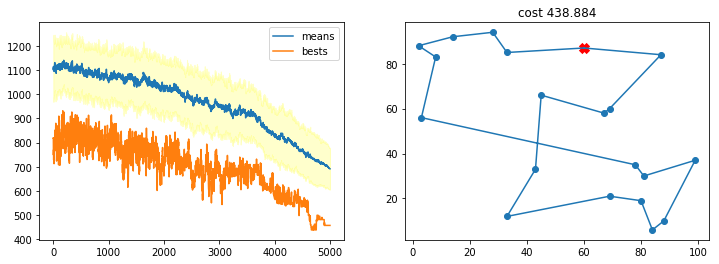

In [19]:
%run code/sa.py

n_individuals = 100
n_cooling_steps = 5000

bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour)


TSP_plot_result(bestsol, bests, means, stds)

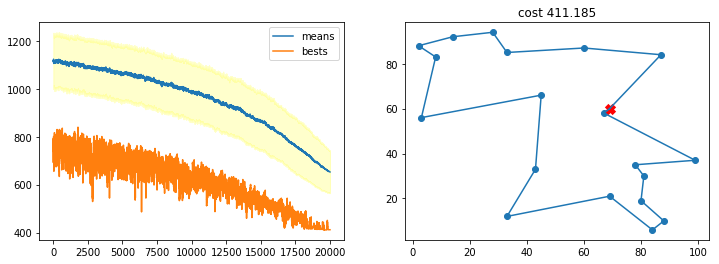

In [22]:
%run code/sa.py

n_individuals = 1000
n_cooling_steps = 20000

bestsol, bests, means, stds = run_sa(n_individuals              = n_individuals, 
                                     n_cooling_steps            = n_cooling_steps, 
                                     init_population_function   = lambda x: TSP_initialize_population(x, n_cities), 
                                     cost_function              = lambda x: TSP_cost(cities, x),
                                     generate_neighbor_function = TSP_neighbour)


TSP_plot_result(bestsol, bests, means, stds)